# Объединение алгоритмов в цепочки и конвейеры 

**Pipeline** в библиотеке scikit-learn представляет собой удобный инструмент для создания последовательности шагов обработки данных, которые применяются к моделям машинного обучения. Он объединяет несколько этапов работы в один объект, что упрощает кодирование и сделать процесс более чистым и легко воспроизводимым.

In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Этапы машинного обучения выглядят следующим образом

In [2]:
# загружаем и разбиваем данные
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=22)

# масштабируем обучающие данные
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

# строим SVM на масштабированных обучающих данных
svm = SVC()
svm.fit(X_train_scaled, y_train)

# масштабируем тестовые данные
X_test_scaled = scaler.transform(X_test)

# оцениваем качество на масштабированных данных
print("Правильность на тестовом наборе: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Правильность на тестовом наборе: 0.96


*Теперь предположим, мы хотим найти более оптимальные параметры для 
SVC с помощью **GridSearchCV**. Как нам 
выполнить это? Наивный подход может выглядеть следующим образом*

In [3]:
from sklearn.model_selection import GridSearchCV

# ТАК НЕПРАВИЛЬНО:

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Наил знач правильности перекр проверки: {:.2f}".format(grid.best_score_))
print("Наил знач правильности на тесте: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("Наил параметры: ", grid.best_params_)


Наил знач правильности перекр проверки: 0.99
Наил знач правильности на тесте: 0.94
Наил параметры:  {'C': 10, 'gamma': 1}


Проблема заключается в том, что при масштабировании данных для решетчатого поиска параметров модели используются **все данные обучающего набора**. Это приводит к утечке информации, так как часть проверочного блока, использованного при масштабировании, становится частью данных, на которых модель обучается.

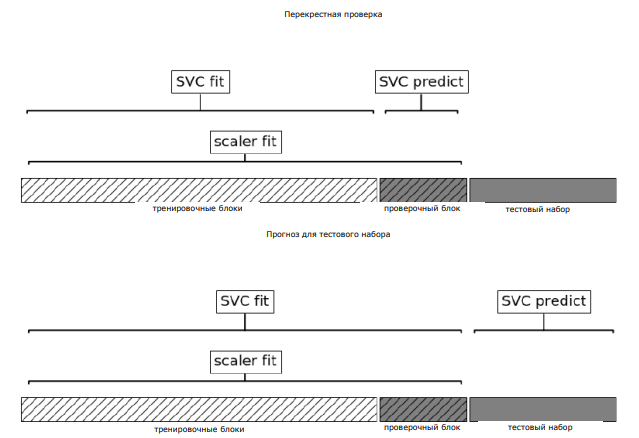

Это может исказить оценки производительности модели на новых данных, так как модель уже знакома с частью информации из проверочного блока. Решение заключается в использовании пайплайна, который включает в себя масштабирование данных и моделирование, применяемого к каждому блоку в кросс-валидации независимо.

Для решения этой задачи в библиотеке **scikit-learn** наряду с
функцией **cross_val_score** и функцией **GridSearchCV** мы можем 
воспользоваться классом **Pipeline**.

Класс Pipeline позволяет «склеивать» вместе несколько операций обработки данных в единую 
модель scikit-learn. Класс Pipeline предусматривает методы **fit**, **predict** и **score** и имеет все те же свойства, что и любая модель scikit-learn. 

*Чаще всего класс Pipeline используется для объединения
операций предварительной обработки (например, масштабирования
Перекрестная проверка
Прогноз для тестового набора
тренировочные блоки проверочный блок тестовый набор
тренировочные блоки проверочный блок тестовый набор
данных) с моделью контролируемого машинного обучения типа 
классификатора*

## Построение конвейеров

Давайте посмотрим, как мы можем использовать класс **Pipeline**, чтобы 
осуществить обучение SVM после масштабирования данных с помощью
**MinMaxScaler**. 

Во-первых, мы создаем **объект-конвейер**, передав ему **список необходимых 
этапов** . Каждый этап представляет собой кортеж, содержащий *имя* и *экземпляр модели*.

In [4]:
from sklearn.pipeline import Pipeline

In [5]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC())])

Здесь мы создали два этапа: первый этап, названный "scaler", 
является экземпляром MinMaxScaler, а второй, названный "svm", является 
экземпляром SVC. Теперь мы можем обучить конвейер точно так же, 
как и любую другую модель scikit-learn.

In [6]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

В данном случае pipe.fit сначала вызывает метод fit объекта 
scaler, преобразует обучающие данные, используя MinMaxScaler, и, 
наконец, строит модель SVM на основе масштабированных данных

In [7]:
print(f'Правильность на тестовом наборе: {pipe.score(X_test, y_test):.2}')

Правильность на тестовом наборе: 0.96


Когда мы вызываем pipe.score, сначала тестовые данные
масштабируются с помощью MinMaxScaler, затем к масштабированным
тестовым данным применяется построенная модель SVM (происходит 
вызов метода score объекта svm).

### Использование конвейера в объекте GridSearchCV

Мы задаем сетку параметров для 
поиска и строим GridSearchCV на основе конвейера и сетки параметров. 
Однако теперь определение сетки параметров выглядит несколько иначе. 
Для каждого параметра нам нужно указать этап конвейера, к которому
он относится. Оба параметра, которые мы хотим скорректировать, C и 
gamma являются параметрами SVC, то есть относятся ко второму этапу. 
Мы назвали этот этап "svm". Синтаксис, позволяющий настроить сетку
параметров для конвейера, заключается в том, чтобы для каждого 
параметра указать имя этапа, затем символ двойного подчеркивания _._, 
а потом имя параметра. Чтобы выполнить поиск по параметру C для SVC,
мы в качестве ключа (сетка параметров представляет собой словарь) 
должны задать "svm__C", затем ту же самую процедуру нужно выполнить
для gamma.

In [8]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

In [9]:
print("Наил значение правильности перекр проверки: {:.2f}".format(grid.best_score_))
print("Правильность на тестовом наборе: {:.2f}".format(grid.score(X_test, y_test)))
print("Наилучшие параметры: {}".format(grid.best_params_))

Наил значение правильности перекр проверки: 0.99
Правильность на тестовом наборе: 0.94
Наилучшие параметры: {'svm__C': 10, 'svm__gamma': 1}


*В отличие от решетчатого поиска, выполненного ранее, теперь для 
каждого разбиения перекрестной проверки MinMaxScaler выполняет 
масштабирование данных, используя лишь обучающие блоки разбиений,
и теперь информация тестового блока не передается модели при поиске
параметров.*

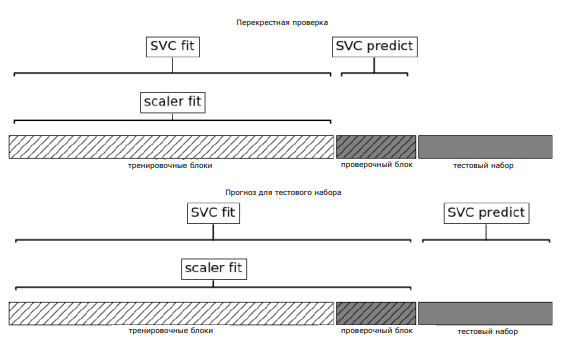

Класс Pipeline не ограничивается предварительной обработкой и 
классификацией, с его помощью можно объединить любое количество 
моделей. Например, можно создать конвейер, включающий в себя
выделение признаков, отбор признаков, масштабирование и 
классификацию, в общей сложности четыре этапа. Кроме того, 
последним этапом вместо классификации может быть регрессия или 
кластеризация.

Единственное требование, предъявляемое к моделям в конвейере,
заключается в том, что все этапы, кроме последнего, должны
использовать метод **transform**, таким образом, они позволяют
сгенерировать новое представление данных, которое можно использовать
на следующем этапе.

In [10]:
pipe.steps

[('scaler', MinMaxScaler()), ('svm', SVC())]

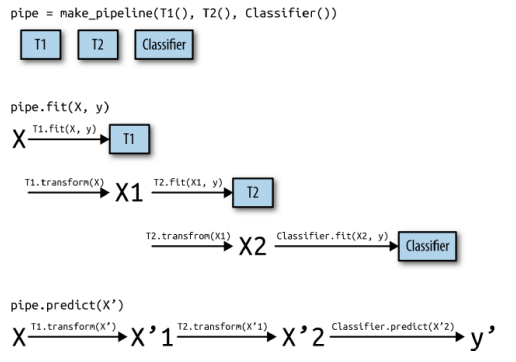

Построение конвейера с помощью вышеописанного синтаксиса иногда 
выглядит немного громоздким и, как правило, нам нет необходимости 
присваивать имя каждому этапу. Существует удобная функция 
make_pipeline, которая позволяет создать конвейер и автоматически 
присвоить имя каждому этапу, исходя из его класса

In [11]:
from sklearn.pipeline import make_pipeline
# стандартный синтаксис
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# сокращенный синтаксис
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [12]:
pipe_short

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))])

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())

print("Этапы конвейера:\n{}".format(pipe.steps))

Этапы конвейера:
[('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


### Работа с атрибутами этапов

Часто бывают ситуации, когда вам нужно посмотреть атрибуты одного 
из этапов конвейера, например, коэффициенты линейной модели или 
компоненты, извлекаемые с помощью PCA

In [14]:
# обучаем ковейер на данных
pipe.fit(cancer.data)

Pipeline(steps=[('standardscaler-1', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('standardscaler-2', StandardScaler())])

In [15]:
pipe.named_steps

{'standardscaler-1': StandardScaler(),
 'pca': PCA(n_components=2),
 'standardscaler-2': StandardScaler()}

In [16]:
pipe.named_steps['pca'] # PCA

PCA(n_components=2)

In [17]:
pipe.named_steps['pca'].components_

array([[ 0.21890244,  0.10372458,  0.22753729,  0.22099499,  0.14258969,
         0.23928535,  0.25840048,  0.26085376,  0.13816696,  0.06436335,
         0.20597878,  0.01742803,  0.21132592,  0.20286964,  0.01453145,
         0.17039345,  0.15358979,  0.1834174 ,  0.04249842,  0.10256832,
         0.22799663,  0.10446933,  0.23663968,  0.22487053,  0.12795256,
         0.21009588,  0.22876753,  0.25088597,  0.12290456,  0.13178394],
       [-0.23385713, -0.05970609, -0.21518136, -0.23107671,  0.18611302,
         0.15189161,  0.06016536, -0.0347675 ,  0.19034877,  0.36657547,
        -0.10555215,  0.08997968, -0.08945723, -0.15229263,  0.20443045,
         0.2327159 ,  0.19720728,  0.13032156,  0.183848  ,  0.28009203,
        -0.21986638, -0.0454673 , -0.19987843, -0.21935186,  0.17230435,
         0.14359317,  0.09796411, -0.00825724,  0.14188335,  0.27533947]])

In [18]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [19]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [20]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [21]:
# лучшая модель

grid.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])

In [22]:
grid.best_estimator_.named_steps["logisticregression"]

LogisticRegression(C=1, max_iter=1000)

In [23]:
# доступ к модели

grid.best_estimator_.named_steps["logisticregression"].coef_

array([[-0.43570655, -0.34266946, -0.40809443, -0.5344574 , -0.14971847,
         0.61034122, -0.72634347, -0.78538827,  0.03886087,  0.27497198,
        -1.29780109,  0.04926005, -0.67336941, -0.93447426, -0.13939555,
         0.45032641, -0.13009864, -0.10144273,  0.43432027,  0.71596578,
        -1.09068862, -1.09463976, -0.85183755, -1.06406198, -0.74316099,
         0.07252425, -0.82323903, -0.65321239, -0.64379499, -0.42026013]])

### Оптимальные параметры этапов конвейра

In [24]:
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,random_state=0)
 
from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge());
pipe

C:\Users\dermi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('ridge', Ridge())])

Как мы узнаем, какие степени полиномов нужно выбрать, выбирать 
ли полиномы или взаимодействия вообще? В идеале мы хотим выбрать 
значение параметра degree, основываясь на результатах классификации. 
С помощью нашего конвейера мы можем осуществить поиск значений 
параметра degree для полиномиальных преобразований значениями
одновременно с поиском значений параметра alpha модели гребневой 
регрессии.

In [25]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [26]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

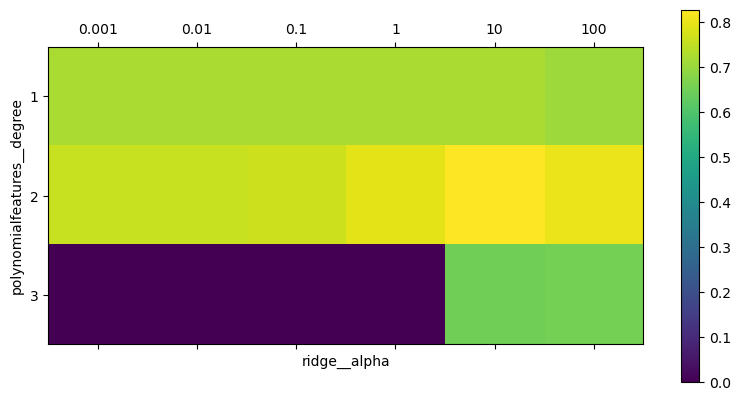

In [27]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
 vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
 param_grid['polynomialfeatures__degree'])
plt.colorbar()

In [28]:
print("Наилучшие параметры: {}".format(grid.best_params_))

Наилучшие параметры: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [29]:
print("R-квадрат на тестовом наборе: {:.2f}".format(grid.score(X_test, y_test)))

R-квадрат на тестовом наборе: 0.77


In [30]:
# без полиномов

param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("R-квадрат без полином. преобразования: {:.2f}".format(grid.score(X_test, y_test)))

R-квадрат без полином. преобразования: 0.63


*Одновременный поиск параметров предварительной обработки и
параметров модели является очень мощной стратегией. Однако имейте в 
виду, что GridSearchCV перебирает все возможные комбинации заданных
параметров. Поэтому включение в сетку большего количества 
параметров ведет к экспоненциальному росту моделей.*

### Зайти еще дальше - выбор оптимальной МОДЕЛИ !

Вы можете пойти дальше, объединив GridSearchCV и Pipeline: можно 
осуществлять поиск лишь по фактическим этапам, выполняемым в 
конвейере (например, речь может идти о целесообразности 
использования StandardScaler или MinMaxScaler). Подобное действие
приведет к еще большему пространству поиска и нужно тщательно 
взвесить его целесообразность. Как правило, перебор всех возможных
моделей не является оптимальной стратегией машинного обучения. 

Мы знаем, что SVC, возможно, потребуются отмасштабированные данные, поэтому 
необходимо решить, использовать StandardScaler или обойтись без 
предварительной обработки. Что касается RandomForestClassifier, мы 
знаем, что для него предварительная обработка данных не требуется.

In [31]:
# стратегия для SVC
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
param_grid = [
 {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
 'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
 'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
 {'classifier': [RandomForestClassifier(n_estimators=100)],
 'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
 
print("Наилучшие параметры:\n{}\n".format(grid.best_params_))
print("Наил значение правильности перекр проверки: {:.2f}".format(grid.best_score_))
print("Правильность на тестовом наборе: {:.2f}".format(grid.score(X_test, y_test)))

*По итогам решатчатого поиска становится ясно, что модель SVC с 
предварительной обработкой StandardScaler, параметрами C=10 и 
gamma=0.01 дает наилучший результат*

## Вместо вывода

**Pipeline** в scikit-learn предоставляет удобный способ объединить этапы обработки данных и моделирования, упрощая код, предотвращая утечки информации, улучшая читаемость и обеспечивая единый интерфейс для обучения и предсказания моделей. Это способствует более структурированному и легкочитаемому коду, а также обеспечивает повышенную воспроизводимость результатов в машинном обучении.

*Использование конвейеров довольно существенно облегчает 
«экспериментирование» с различными операциями предварительной 
обработки данных. При проведении экспериментов постарайтесь не 
слишком усложнять процессы подготовки данных и убедитесь в том, что 
каждый оцениваемый компонент, включенный в ваш конвейер, является 
необходимым этапом.*